# **GPU Demo Part 2 - Decoupler-GPU: Accelerated Transcriptional Regulatory Analysis**  

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

**Please run [GPU Demo Part 1 - Basic GPU E2E Workflow](01_demo_gpu_e2e.ipynb) before running this notebook as this notebook continues some analysis of that notebook's output.**

In this notebook, we explore the updated [**Decoupler**](https://decoupler-py.readthedocs.io/en/latest/) functions for inferring transcriptional regulatory activity, leveraging the **GPU-accelerated** implementation from **rapids-singlecell**.  

By running these analyses on GPUs, we achieve **faster computation** and **scalability** for large single-cell datasets. We will apply **Decoupler** methods to estimate **transcription factor (TF) activity** and **pathway activity**, utilizing curated regulatory networks such as **Dorothea** and **PROGENy**.

In [1]:
import rapids_singlecell as rsc
import scanpy as sc
import rmm
import cupy as cp
import pandas as pd
import anndata as ad
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=True, # default is False
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
adata = sc.read_h5ad("./h5/dli_decoupler.h5ad")

In [3]:
adata = adata.raw.to_adata()

In [4]:
rsc.get.anndata_to_GPU(adata)

### Retrieving Transcription Factor (TF) Regulons with Dorothea  

We start by retrieving the **Dorothea** gene regulatory network, which provides curated transcription factor (TF) target interactions.  
Dorothea assigns confidence levels (`A`, `B`, `C`, `D`, `E`), where `A` represents the highest confidence interactions.  
Here, we filter for **high-confidence** (`A`, `B`, `C`) interactions in human data:  

In [5]:
net = pd.read_parquet("nets/dorothea.parquet")

### Transcription Factor Activity Inference with ULM  

To infer transcription factor (TF) activity, we use the **Univariate Linear Model (ULM)** from **Decoupler**.  
ULM estimates the regulatory influence of TFs on gene expression by fitting a linear model for each TF-gene interaction.  

We apply **ULM** using the **Dorothea** regulatory network retrieved earlier. 

In [6]:
%%time
rsc.dcg.ulm(adata, net, verbose=True, raw = False, pre_load=True)

2026-02-18 21:17:14 | [INFO] ulm - Running ulm
2026-02-18 21:17:14 | [INFO] Network adjacency matrix has 8646 unique features and 295 unique sources


  0%|          | 0/43 [00:00<?, ?it/s]

2026-02-18 21:17:14 | [INFO] ulm - fitting 295 univariate models of 25430 observations (targets) with 25428 degrees of freedom
2026-02-18 21:17:14 | [INFO] ulm - adjusting p-values by FDR
2026-02-18 21:17:15 | [INFO] ulm - done


CPU times: user 4.13 s, sys: 216 ms, total: 4.34 s
Wall time: 1.15 s


In [7]:
acts = ad.AnnData(X=adata.obsm["score_ulm"], obs=adata.obs, obsm=adata.obsm)

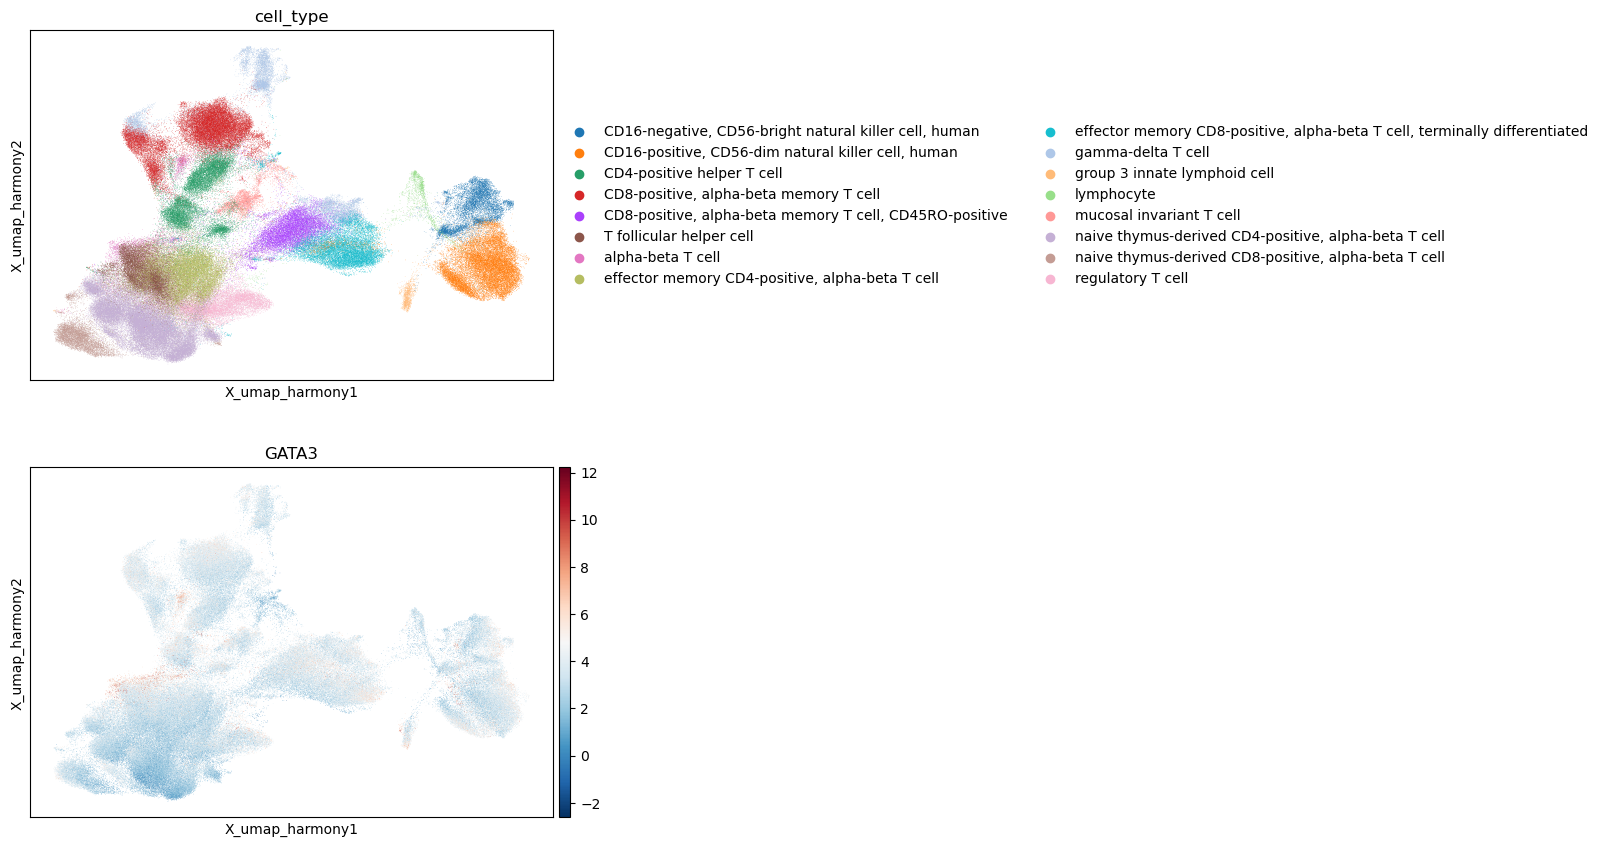

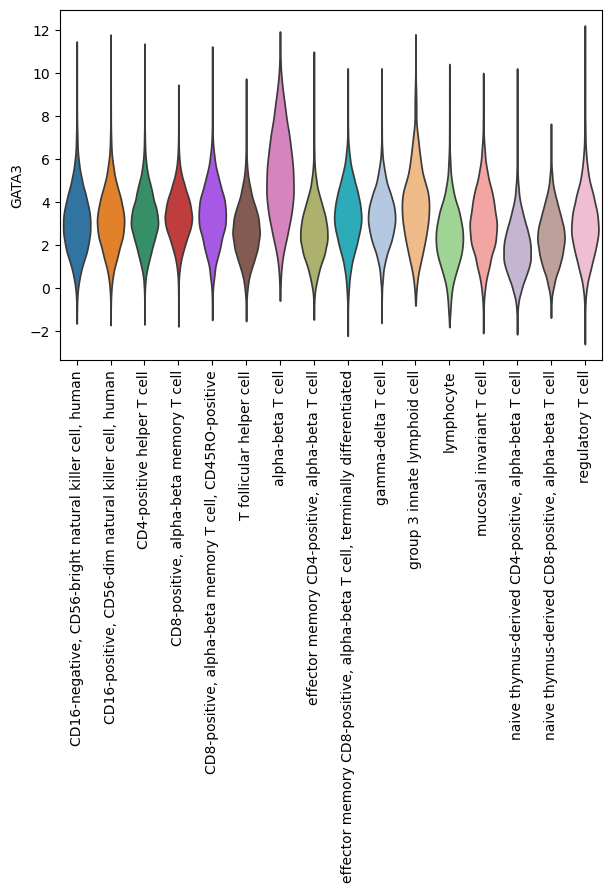

In [8]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Transcription Factor Activity Inference with MLM  

Next, we infer transcription factor (TF) activity using the **Multivariate Linear Model (MLM)** from **Decoupler**.  
Unlike **ULM**, which considers each TF independently, **MLM** accounts for multiple TFs simultaneously,  
providing a more comprehensive estimation of regulatory influences. 

In [9]:
%%time
rsc.dcg.mlm(adata, net, verbose=True, raw = False, pre_load=True)

2026-02-18 21:17:17 | [INFO] mlm - Running mlm
2026-02-18 21:17:17 | [INFO] Network adjacency matrix has 8646 unique features and 295 unique sources


  0%|          | 0/43 [00:00<?, ?it/s]

2026-02-18 21:17:17 | [INFO] mlm - fitting 295 multivariate models of 25430 observations with 25134 degrees of freedom
2026-02-18 21:17:19 | [INFO] mlm - done


CPU times: user 1.6 s, sys: 226 ms, total: 1.83 s
Wall time: 1.82 s


### Transcription Factor Activity Inference with AUCell  

Next, we infer transcription factor (TF) activity using **AUCell** from **Decoupler**.  
AUCell estimates TF activity based on the **enrichment of TF target genes within the top-expressed genes** in each cell.  
Unlike regression-based methods (**ULM**, **MLM**), AUCell is a **rank-based approach** that does not assume linear relationships. 

In [10]:
%%time
rsc.dcg.aucell(adata, net, verbose=True, raw = False, pre_load=True)

2026-02-18 21:17:19 | [INFO] aucell - Running aucell
2026-02-18 21:17:19 | [INFO] Network has 8646 unique features and 295 unique sources


  0%|          | 0/2131 [00:00<?, ?it/s]

2026-02-18 21:17:19 | [INFO] aucell - calculating 295 AUCs for 25430 targets across 100 observations, categorizing features at rank=1272
2026-02-18 21:17:22 | [INFO] aucell - done


CPU times: user 3.42 s, sys: 13.1 ms, total: 3.44 s
Wall time: 3.43 s


In [11]:
acts = ad.AnnData(X=adata.obsm["score_aucell"], obs=adata.obs, obsm=adata.obsm)

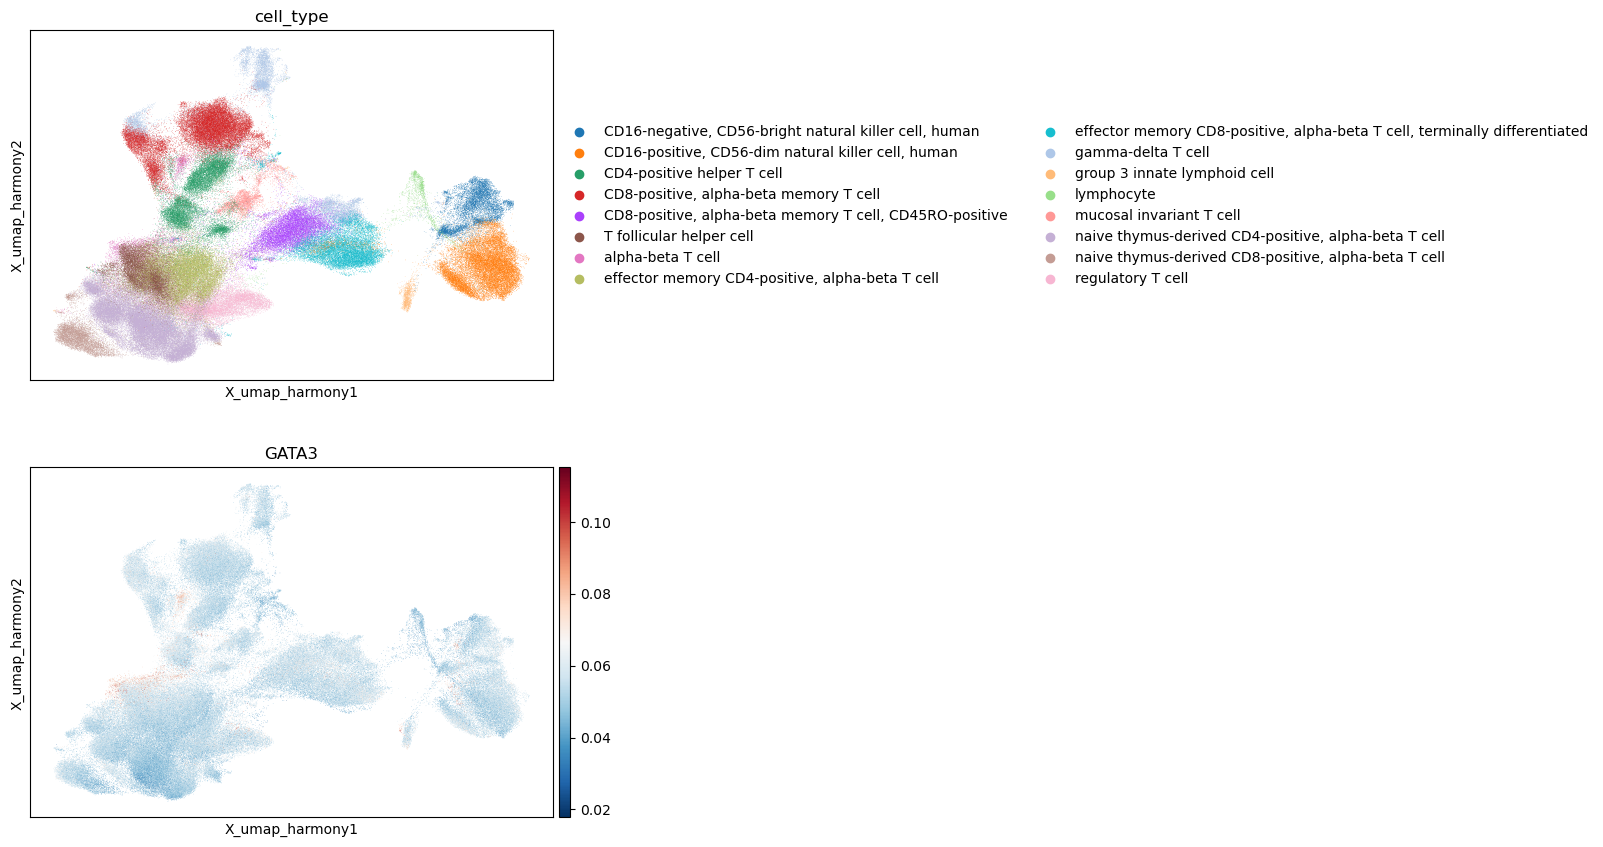

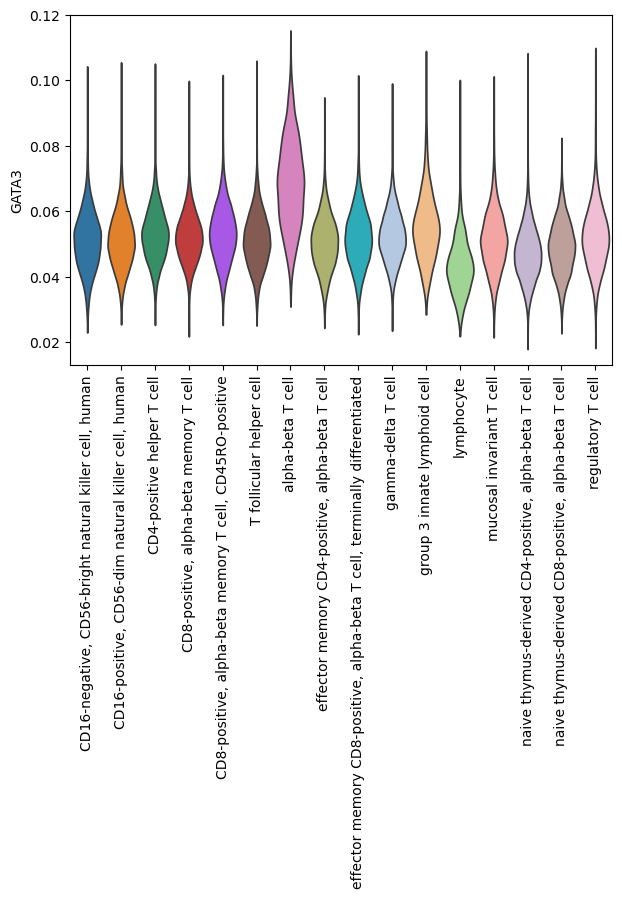

In [12]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Retrieving Pathway Activity Models with PROGENy  

To assess pathway activity, we use **PROGENy**, a curated model that links gene expression to pathway activity scores.  
PROGENy provides a **data-driven** approach to infer the activity of major signaling pathways  
by leveraging transcriptional signatures derived from perturbation experiments.  

We retrieve the **top 100 most informative target genes** for each pathway in **human** data  

In [13]:
model = pd.read_parquet("nets/progeny.parquet")

In [14]:
# These notebooks are very GPU memory intensive!
# In order to free up GPU memory, we'll kill this kernel prior to proceeding.  You will get a message.  This is expected.
# If you have a CUDA or an Out Of Memory (OOM) error, please kill all kernels to free up your GPU memory and try again!
# You can comment this out if you want to continue exploring the notebook.
# Please consult the README for more tips and tricks.

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}